# **A deep learning approach for Deep Fake Video Detection**

# XceptionNet + RNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install MTCNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.2 MB/s eta 0:00:00


In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.7 MB/s eta 0:00:00


In [ ]:
# import the required libraries
import os
import cv2
import csv
import shutil
import numpy as np
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [ ]:
videos_folder = '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos'
print(os.listdir(videos_folder))

['apedduehoy.mp4', 'clzkcmoyhb.mp4', 'dhjnjkzuhq.mp4', 'dtjcyzgdts.mp4', 'ejhhdlzpjg.mp4', 'exseruhiuk.mp4', 'fckxaqjbxk.mp4', 'fufcmupzen.mp4', 'fzvpbrzssi.mp4', 'hplxtssgnz.mp4', 'htorvhbcae.mp4', 'lokzwdldxp.mp4', 'owxbbpjpch.mp4', 'pqdeutauqc.mp4', 'prdrkaxeob.mp4', 'rnpefxwptv.mp4', 'sphirandia.mp4', 'sttnfyptum.mp4', 'sxyrkshzsg.mp4', 'syxobtuucp.mp4', 'uaukglhmje.mp4', 'uqtqhiqymz.mp4', 'uvfkppqsjy.mp4', 'viuioldtnu.mp4', 'vpmyeepbep.mp4', 'vpjfmetsvn.mp4', 'vsmadeuczx.mp4', 'vtunvalyji.mp4', 'vvwuqslvnq.mp4', 'wfzjxzhdkj.mp4', 'wnaweyzlqh.mp4', 'xcruhaccxc.mp4', 'xjzkfqddyk.mp4', 'xugmhbetrw.mp4', 'yexeazbqig.mp4', 'ztwlbdwyni.mp4', 'hivnldfvyl.mp4', 'jawgcggquk.mp4', 'iafvzgpbix.mp4', 'komngcqveq.mp4', 'kmcdjxmnoa.mp4', 'jkxjvuioek.mp4', 'idczhqbbqz.mp4', 'kedahvzait.mp4', 'lnhkjhyhvw.mp4', 'jaurxwocly.mp4', 'muksyyltmg.mp4', 'qyqufaskjs.mp4', 'ohaqlzfnuv.mp4', 'rfpjsloxzg.mp4']


## Video Classification with Xception + RNN

https://keras.io/examples/vision/video_classification/

In [ ]:
#pip install tensorflow_docs

In [ ]:
# from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/trainLabels (1).csv', dtype=str)
train_df.head()

,Filename,label
0,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
1,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
2,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
3,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
4,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL


In [ ]:
test_df = pd.read_csv('/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/testLabels (1).csv', dtype=str)
test_df.head()

,Filename,label
0,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
1,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
2,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
3,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL
4,/content/drive/Shareddrives/DATA255_Dataset/Da...,REAL


In [ ]:
test_df["Filename"][0]

'/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/prdrkaxeob.mp4'

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 40
Total videos for testing: 10


In [ ]:
BATCH_SIZE = 32
EPOCHS = 30
IMG_SIZE = 224
MAX_SEQ_LENGTH = 50
NUM_FEATURES = 2048


## Face extractor

In [ ]:
from mtcnn import MTCNN
from google.colab.patches import cv2_imshow
detector = MTCNN()

In [ ]:
def load_video(path, max_frames=15, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    count = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            result = detector.detect_faces(frame)
            if len(result) > 0:
                x, y, w, h = result[0]['box']
                face = frame[y:y+h, x:x+w, :]
                face = cv2.resize(face, resize)
                face = face[:, :, [2, 1, 0]]
                frames.append(face)
                count += 1
                print(count)
            if count == max_frames:
                break
        count = 0  # Reset count for the next video
    finally:
        cap.release()

    return np.array(frames)


In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.xception.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["label"])
)
print(label_processor.get_vocabulary())

['FAKE', 'REAL']


In [ ]:
# For extracting 
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["Filename"].values.tolist()
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        print("video_count" , idx)
        print(path)

        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        # frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        # Extract features from the frames of the current video.
        count = 0
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
            count += length

        # Update the `frame_features` and `frame_masks` arrays.
        frame_features[idx, :count, :] = temp_frame_features.squeeze()[:count, :]
        frame_masks[idx, :count] = temp_frame_mask.squeeze()[:count]

        # Save the frame_features and frame_masks arrays
        np.save(os.path.join(root_dir, 'frame_features.npy'), frame_features)
        np.save(os.path.join(root_dir, 'frame_masks.npy'), frame_masks)
        np.save(os.path.join(root_dir, 'labels.npy'), labels)

    # return (frame_features, frame_masks), labels



## For Evaluation

In [ ]:
# run for extracting the features and masks for the 1st time
# prepare_all_videos(train_df, train_data_path)
# prepare_all_videos(test_df, test_data_path)

In [ ]:

# To import the stored train data:

# Load the saved data using numpy's load function.
loaded_train_data = np.load("/content/drive/Shareddrives/DATA255_Dataset/Train/prepared_train_data.npz")

# Retrieve the individual arrays from the loaded data.
frame_features = loaded_train_data["frame_features"]
frame_masks = loaded_train_data["frame_masks"]
train_labels = loaded_train_data["labels"]

# Reconstruct the prepared_data tuple.
train_data = (frame_features, frame_masks)

In [ ]:
# To import the stored test data:

# Load the saved data using numpy's load function.
loaded_test_data = np.load("/content/drive/Shareddrives/DATA255_Dataset/Test/prepared_test_data.npz")

# Retrieve the individual arrays from the loaded data.
frame_features = loaded_test_data["frame_features"]
frame_masks = loaded_test_data["frame_masks"]
test_labels = loaded_test_data["labels"]

# Reconstruct the prepared_data tuple.
test_data = (frame_features, frame_masks)

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    rnn_model.summary()
    return rnn_model



In [ ]:
print(train_data[0].shape)

(38, 50, 2048)


In [ ]:
print(train_data[1].shape)

(38, 50)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Utility for running experiments.
def run_experiment():
    # Initialize arrays to store accuracy values from each fold.
    accuracies = []
    # Initialize arrays to store accuracy values from each fold.
    fold_train_loss = []
    fold_val_loss = []
    fold_train_acc = []
    fold_val_acc = []

    fold_no = 1
    
    # Initialize KFold cross-validation.
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the model checkpoint callback.
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    # Loop over the folds.
    for train_idx, val_idx in kfold.split(train_data[0]):
        print(f"Fold {fold_no}...")
        fold_no += 1
        
        # Split the training data into training and validation sets.
        x_train = [train_data[0][train_idx], train_data[1][train_idx]]
        y_train = train_labels[train_idx]
        x_val = [train_data[0][val_idx], train_data[1][val_idx]]
        y_val = train_labels[val_idx]

        # Create the model and compile it.
        seq_model = get_sequence_model()
        # seq_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        # Train the model on the current fold.
        history = seq_model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=EPOCHS,
            callbacks=[checkpoint],
        )

        # Append the training and validation loss and accuracy to the respective lists.
        fold_train_loss.append(history.history['loss'])
        fold_val_loss.append(history.history['val_loss'])
        fold_train_acc.append(history.history['accuracy'])
        fold_val_acc.append(history.history['val_accuracy'])

        # Evaluate the model on the test set and store the accuracy.
        seq_model.load_weights(filepath)
        _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
        accuracies.append(accuracy)
        print(f"Fold {fold_no - 1} test accuracy: {round(accuracy * 100, 2)}%")

    # Convert the lists to numpy arrays.
    fold_train_loss = np.array(fold_train_loss)
    fold_val_loss = np.array(fold_val_loss)
    fold_train_acc = np.array(fold_train_acc)
    fold_val_acc = np.array(fold_val_acc)

    # Compute the average values across the folds for each epoch.
    avg_train_loss = np.mean(fold_train_loss, axis=0)
    avg_val_loss = np.mean(fold_val_loss, axis=0)
    avg_train_acc = np.mean(fold_train_acc, axis=0)
    avg_val_acc = np.mean(fold_val_acc, axis=0)
    
    # Calculate mean and standard deviation of accuracies across all folds.
    mean_accuracy = np.mean(accuracies)
    std_dev_accuracy = np.std(accuracies)

    print(f"Mean test accuracy: {round(mean_accuracy * 100, 2)}% +/- {round(std_dev_accuracy * 100, 2)}%")

    epochs = range(1, len(avg_train_loss) + 1)

    # Loss curve
    # plt.figure()
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_train_loss, 'b', label='Average Training Loss')
    plt.plot(epochs, avg_val_loss, 'r', label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curve
    # plt.figure()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_train_acc, color='green', label='Average Training Accuracy')
    plt.plot(epochs, avg_val_acc,  color='orange', label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plots
    plt.show()

    return seq_model

In [ ]:
seq_model = get_sequence_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 2048)]   0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 50, 16)       99168       ['input_6[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']              

Fold 1...
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50, 2048)]   0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 50, 16)       99168       ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 gru_3 (GRU)                    (None, 8)            624         ['gru_2[0][0]']  

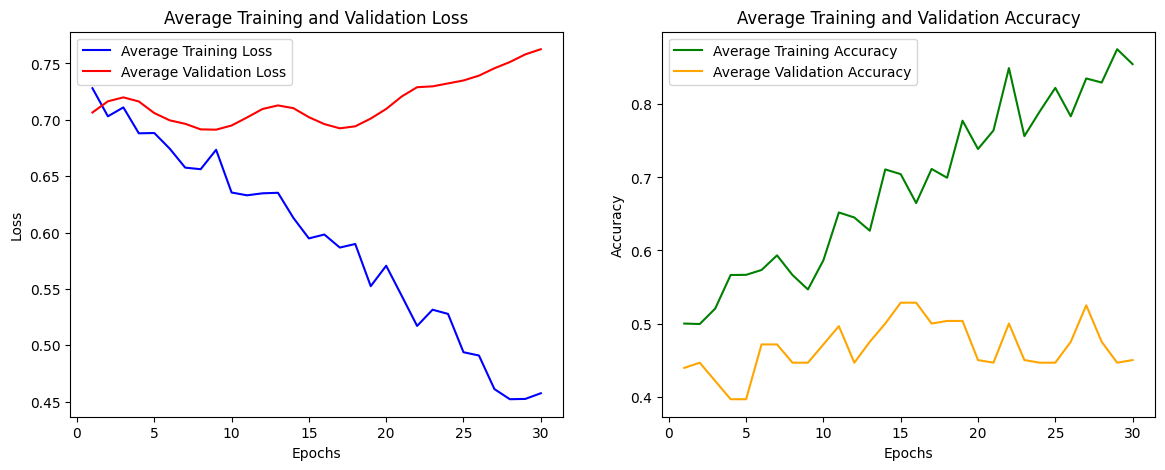

In [ ]:
trained_model = run_experiment()

Result Analysis:  The results change everytime we run, so we took the ones with best performance

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = trained_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


In [ ]:
test_video = np.random.choice(test_df["Filename"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)

Test video path: /content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/xjzkfqddyk.mp4
1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 23ms/step
2
1/1 [==============================] - 0s 20ms/step
3
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 18ms/step
5
1/1 [==============================] - 0s 26ms/step
6
1/1 [==============================] - 0s 21ms/step
7
1/1 [==============================] - 0s 18ms/step
8
1/1 [==============================] - 0s 149ms/step
9
1/1 [==============================] - 0s 29ms/step
10
1/1 [==============================] - 0s 28ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 19ms/step
13
1/1 [==============================] - 0s 20ms/step
14
1/1 [==============================] - 0s 21ms/step
15
1/1 [==============================] - 3s 3s/step
  REAL: 81.15%
  FAKE: 18.85%


In [ ]:
test_video = '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/xjzkfqddyk.mp4'
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)

Test video path: /content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/xjzkfqddyk.mp4
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 19ms/step
2
1/1 [==============================] - 0s 22ms/step
3
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 24ms/step
6
1/1 [==============================] - 0s 23ms/step
7
1/1 [==============================] - 0s 27ms/step
8
1/1 [==============================] - 0s 35ms/step
9
1/1 [==============================] - 0s 35ms/step
10
1/1 [==============================] - 0s 37ms/step
11
1/1 [==============================] - 0s 27ms/step
12
1/1 [==============================] - 0s 21ms/step
13
1/1 [==============================] - 0s 28ms/step
14
1/1 [==============================] - 0s 23ms/step
15
1/1 [==============================] - 0s 35ms/step
  REAL: 81.15%
  FAKE: 18.85%


In [ ]:
test_video = '/content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4'
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)

Test video path: /content/drive/Shareddrives/DATA255_Dataset/Dataset/Sample50/Videos/lokzwdldxp.mp4
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 142ms/step
2
1/1 [==============================] - 0s 19ms/step
3
1/1 [==============================] - 0s 152ms/step
4
1/1 [==============================] - 0s 19ms/step
5
1/1 [==============================] - 0s 21ms/step
6
1/1 [==============================] - 0s 18ms/step
7
1/1 [==============================] - 0s 20ms/step
8
1/1 [==============================] - 0s 20ms/step
9
1/1 [==============================] - 0s 29ms/step
10
1/1 [==============================] - 0s 28ms/step
11
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 23ms/step
13
1/1 [==============================] - 0s 27ms/step
14
1/1 [==============================] - 0s 18ms/step
15
1/1 [==============================] - 0s 22ms/step
  REAL: 84.63%
  FAKE: 15.37%